# Imports

In [1]:
import pandas as pd; import os; from analysis_helpers import *; import warnings
warnings.filterwarnings('ignore')

# Data Compile
This cell takes a long time to run. 

It will print each participant number to give a sense of the progress (finishing at paticipant 112).

In [2]:
# Compile data from all exps

all_data = []
all_gaze = []

a,b = '../sustained_attention_experiment/data/','../variable_attention_experiment/data/'
data_dirs = [a+'group1', a+'group2', b+'group1', b+'group2'] 
filenames = [x+'_aggregate.csv' for x in data_dirs]

sub_count = 0

# for each group (1 & 2) in each experiment (sustained and variable)
for data,file in zip(data_dirs, filenames):
    
    # empty subject list
    sub_list = []
    
    # for each subject in this directory
    for sub_dir in os.listdir(data):
        print(sub_dir)
        if sub_dir != '.DS_Store' and sub_dir != 'README.md':
            
            # add attention labels to memory stim 
            subject = add_level(sum_pd(data + '/' + sub_dir))

            # If Group 1 (Sustained or Variable)
            if data[-1] == '1':
                
                # TIMING CORRRECTIONS (for gaze)
               
                # github Issue #83, Check B: times in behavioral csv's (Group1) imprecise by fractions of a second
                # correct for those timing issues (for gaze analysis), using safest estimates 
                
                # SUSTAINED: cued composite starts .0178 seconds earlier; VAR : .0167 earlier 
                # SUSTAINED: composites disappear 0.0322 secs later; VARIABLE: .0359 secs 
                subject.loc[subject['Trial Type']=='Presentation','Stimulus Onset'] = subject[subject['Trial Type']=='Presentation']['Stimulus Onset'] - .0178
                subject.loc[subject['Trial Type']=='Presentation','Stimulus End']   = subject[subject['Trial Type']=='Presentation']['Stimulus End']   + .0359
                  
                # SUST: mem images display 0.0179 earlier; VAR: .0142
                # SUST: mem images disappear .259 secs later; VAR: .137
                subject.loc[subject['Trial Type']=='Memory','Stimulus Onset'] = subject[subject['Trial Type']=='Memory']['Stimulus Onset'] - .0179
                subject.loc[subject['Trial Type']=='Memory','Stimulus End']   = subject[subject['Trial Type']=='Memory']['Stimulus End']   +.259
                
                # NOTE: no correction for button press timing differences, as they averaged .001 seconds or less

                if data == '../variable_attention_experiment/data/group1':
                    
                    # EXP 2 cue corrections ---------------
                    # github Issue #83, Check E: some Group1, Variable Experiment valid cues marked as invalid cues
                    
                    # correct cue labels Variable Experiment, Group 1
                    for run in subject['Run'].unique():
                        first_cue = list(subject[(subject['Run']==run) & (subject['Trial Type']=='Presentation')]['Cued Side'])
                        if subject[(subject['Run']==run) & (subject['Cue Validity']==0) & (subject['Cued Side'] != first_cue[0])].shape[0]>0:
                            subject.loc[(subject['Run']==run) & (subject['Cue Validity']==0) & (subject['Cued Side'] != first_cue[0]), 'Cue Validity'] = 1
            
            # if Group 2 (Sustained or Variable)
            if data[-1] == '2':
                
                # add ON and OFF stim times for group 2
                subject_log = list_logs(data + '/' + sub_dir + '/')
                subject_log['Subject'] = pd.to_numeric(subject_log['Subject'])
                subject_log = subject_log.sort_values(by=['Subject','Run','TIME'])
                subject = subject.sort_values(by=['Subject','Run'])
                
                # now, extract desired stim on and off times from log files
                composite_onsets  = subject_log[subject_log[0].str.contains('COMPOSITES ON')]
                composite_offsets = subject_log[subject_log[0].str.contains('COMPOSITES OFF')]
                memory_onsets  = list(subject_log[ (subject_log[0].str.contains('MEMORY ON')) & (subject_log[0].str.contains('FLIP')) ]['TIME'])
                memory_offsets = list(subject_log[ (subject_log[0].str.contains('MEMORY OFF')) & (subject_log[0].str.contains('FLIP')) ]['TIME'])
                # attention_on = composite_offsets 
                
                # add ON and OFF stim times for group 2
                subject.loc[subject['Trial Type']=='Presentation', 'Stimulus Onset'] = list(composite_onsets['TIME'])
                subject.loc[subject['Trial Type']=='Presentation', 'Stimulus End'  ] = list(composite_offsets['TIME'])
                subject.loc[subject['Trial Type']=='Presentation','Attention Response Time (s)'] = subject[subject['Trial Type']=='Presentation']['Attention Response Time (s)'] - subject[subject['Trial Type']=='Presentation']['Stimulus End']
                subject.loc[subject['Trial Type']=='Memory', 'Stimulus Onset'] = memory_onsets
                subject.loc[subject['Trial Type']=='Memory', 'Stimulus End'  ] = memory_offsets
                
                
                # Pull attention RT's from log file
                
                # find every probe display, and the next event after each probe display
#                 probe_time_indices = subject_log[(subject_log[0].str.contains('ATTN'))].index
#                 key_press_indices  = [x+1 for x in list(probe_time_indices)]

#                 # if next event isn't keypress 1 or keypress 3, go until you find the first keypress 1 or 3
#                 for idx,x in enumerate(key_press_indices):
#                     while 'Keypress: 1' not in str(subject_log.loc[x][0]) and 'Keypress: 3' not in str(subject_log.loc[x][0]):
#                         x+=1
#                     key_press_indices[idx]=x
#                     # then stop and collect the time of the button press


                attn_rt = {}
                attn_rt['probe_start'] = [] #list(subject_log.loc[probe_time_indices]['TIME'])
                attn_rt['key press' ] = [] #list(subject_log.loc[key_press_indices ]['TIME'])
                a = []
                b=[]
    
                for r in subject_log['Run'].unique():
    
                    run_log = subject_log[subject_log['Run']==r]
    
                   # find every probe display, and the next event after each probe display
                    probe_time_indices = run_log[(run_log[0].str.contains('ATTN'))].index
                    key_press_indices  = [x+1 for x in list(probe_time_indices)]
    
                   # if next event isn't keypress 1 or keypress 3, go until you find the first keypress 1 or 3
                    for idx,x in enumerate(key_press_indices):
                        while 'Keypress: 1' not in str(run_log.loc[x][0]) and 'Keypress: 3' not in str(run_log.loc[x][0]):
                            x+=1
                        key_press_indices[idx]=x
                       # then stop and collect the time of the button press
    
                    a.extend(list(run_log.loc[probe_time_indices]['TIME']))
                    b.extend(list(run_log.loc[key_press_indices ]['TIME']))
    
                attn_rt['probe_start'] = a
                attn_rt['key press' ]  = b
                attn_df = pd.DataFrame(attn_rt)
                log_file_rt = attn_df['key press'].astype('float64')-attn_df['probe_start'].astype('float64')
                subject.loc[subject['Trial Type']=='Presentation','Attention Response Time (s)'] = list(log_file_rt)
                subject.loc[subject['Trial Type']=='Presentation','Attention Reaction Time (s)'] = list(log_file_rt)
            
#                 attn_rt = {}
#                 attn_rt['probe_start'] = list(subject_log.loc[probe_time_indices]['TIME'])
#                 attn_rt['key press' ] = list(subject_log.loc[key_press_indices ]['TIME'])
#                 attn_df = pd.DataFrame(attn_rt)
#                 log_file_rt = attn_df['key press'].astype('float64')-attn_df['probe_start'].astype('float64')
#                 subject.loc[subject['Trial Type']=='Presentation','Attention Response Time (s)'] = log_file_rt
                
                # Convert all times to be eyetribe compatible
                for r in subject['Run'].unique():
                    time = float(subject_log[subject_log['Run']==r].loc[subject_log[subject_log['Run']==r][0].str.contains('urrent time')]['TIME'])
                    curr_string = subject_log[subject_log['Run']==r].loc[subject_log[subject_log['Run']==r][0].str.contains('urrent time')][0].str.split(' ')
                    curr_time = float(list(curr_string)[0][-1])
                    diff = curr_time - time

                    # convert times for each run
                    subject.loc[subject['Run']==r, 'Stimulus Onset'] = subject.loc[subject['Run']==r, 'Stimulus Onset'] + diff
                    subject.loc[subject['Run']==r, 'Stimulus End']   = subject.loc[subject['Run']==r, 'Stimulus End'] + diff
                
                subject = subject.rename(columns={'Attention Response Time (s)': 'Attention Reaction Time (s)'})

            # add trial numbers to behavioral data
            subject['Trial'] = np.nan
            subject.loc[subject['Trial Type']=='Memory','Trial']       = list(range(0,40))*8
            subject.loc[subject['Trial Type']=='Presentation','Trial'] = list(range(0,10))*8
                
            # Gaze data 
            gaze = eye_initial(data + '/' + sub_dir + '/eye_data/')
            gaze = gaze.drop_duplicates('timestamp')
        
            gaze['Subject']  = sub_dir.split('_')[0]
            gaze['UniqueID'] = sub_count
            gaze['Group'] = int(data[-1])
            gaze['Experiment'] = data[2:10]
            
            
            pres_gaze = pres_gaze_from_df(subject, gaze)[0] 
            print('pres_gaze')
            
            # Give every subj unique ID, label group & experiment
            subject['UniqueID'] = sub_count
            subject['Group'] = int(data[-1])
            subject['Experiment'] = data[2:10]
            
            print(sub_count)
            print()
            sub_count += 1
            sub_list.append(subject)
            pres_gaze.to_csv(data + '/' + sub_dir + '/df_pres_gaze_data.csv')
            gaze.to_csv(data + '/' + sub_dir + '/df_gaze_data.csv')
            print('gaze_out')
            
    exp_raw = pd.concat(sub_list)
#     all_gaze.append(pres_gaze)
#     all_data.append(exp_raw)
    exp_raw.to_csv(file)


10_2018_Oct_03
pres_gaze
0

gaze_out
13_2018_Oct_10
pres_gaze
1

gaze_out
02_2018_Sep_26
pres_gaze
2

gaze_out
31_2018_Oct_21
pres_gaze
3

gaze_out
09_2018_Oct_03
pres_gaze
4

gaze_out
24_2018_Oct_17
pres_gaze
5

gaze_out
20_2018_Oct_14
pres_gaze
6

gaze_out
16_2018_Oct_10
pres_gaze
7

gaze_out
36_2018_Oct_24
pres_gaze
8

gaze_out
15_2018_Oct_10
pres_gaze
9

gaze_out
23_2018_Oct_14
pres_gaze
10

gaze_out
27_2018_Oct_17
pres_gaze
11

gaze_out
32_2018_Oct_21
pres_gaze
12

gaze_out
00_2018_Sep_25
pres_gaze
13

gaze_out
17_2018_Oct_10
pres_gaze
14

gaze_out
34_2018_Oct_24
pres_gaze
15

gaze_out
25_2018_Oct_17
pres_gaze
16

gaze_out
08_2018_Oct_03
pres_gaze
17

gaze_out
21_2018_Oct_14
pres_gaze
18

gaze_out
30_2018_Oct_21
pres_gaze
19

gaze_out
06_2018_Sep_28
pres_gaze
20

gaze_out
11_2018_Oct_03
pres_gaze
21

gaze_out
12_2018_Oct_10
pres_gaze
22

gaze_out
07_2018_Oct_03
pres_gaze
23

gaze_out
18_2018_Oct_10
pres_gaze
24

gaze_out
33_2018_Oct_21
pres_gaze
25

gaze_out
22_2018_Oct_14
pres_ga

# Data Save

Save a single, compiled dataframe, containing the data from every participant in the study (n=120)

In [3]:
# compile behavioral df's from groups 1 and 2, variable and sustained
files,exps = ['group1_aggregate.csv', 'group2_aggregate.csv'],['sustained_attention_experiment/data/', 'variable_attention_experiment/data/']

full_four = []
for exp in exps:
    for f in files:
        full_four.append(pd.read_csv('../'+exp+f))

full_behavioral = pd.concat(full_four)
full_behavioral.to_csv('../parsed_data/full_behavioral.csv')

#parsed_data/full_behavioral.csv has ALL behavioral data from ALL participants!

In [4]:
full_behavioral = pd.read_csv('../parsed_data/full_behavioral.csv')

In [5]:
# compile gaze df's from each subject
paths  = ['../sustained_attention_experiment/data/', '../variable_attention_experiment/data/']
groups = ['group1', 'group2']
gaze   = []

for exp in paths:
    for group in groups:
        subjects = os.listdir(exp+group)
        for s in subjects:
            if s != '.DS_Store':
                if 'df_gaze_data.csv' in os.listdir(exp+group+'/'+s+'/'):
                    gaze.append(pd.read_csv(exp+group+'/'+s+'/df_gaze_data.csv'))
                else: 
                    print(s)
                    
gaze_df = pd.concat(gaze)
gaze_df.to_csv('../parsed_data/full_gaze.csv')              

In [6]:
full_gaze = pd.read_csv('../parsed_data/full_gaze.csv')  

In [7]:
# compile gaze df's from each subject
paths  = ['../sustained_attention_experiment/data/', '../variable_attention_experiment/data/']
groups = ['group1', 'group2']
gaze   = []

for exp in paths:
    for group in groups:
        subjects = os.listdir(exp+group)
        for s in subjects:
            if s != '.DS_Store':
                if 'df_pres_gaze_data.csv' in os.listdir(exp+group+'/'+s):
                    gaze.append(pd.read_csv(exp+group+'/'+s+'/df_pres_gaze_data.csv'))
                else:
                    print(s)
                    
gaze_df = pd.concat(gaze)
gaze_df.to_csv('../parsed_data/full_pres_gaze.csv')  

In [8]:
full_pres_gaze = pd.read_csv('../parsed_data/full_pres_gaze.csv')

In [9]:
behav = full_behavioral

# Explore all instances or insufficient or missing gaze data
  
# counter for subs missing full gaze or pres gaze

none = 0

# open full gaze and pres gaze df's for each participant
paths  = ['../sustained_attention_experiment/data/', '../variable_attention_experiment/data/']
groups = ['group1', 'group2']
gaze   = []
g_tri  = []

# make gaze_info dictionary
gaze_info = {'issue':[], 'exp':[], 'group':[], 'subject':[], 'run':[], 'pres':[], 'full':[],
             'file_size':[], 'g_start':[], 'g_end':[], 'p_start':[], 'p_end':[], 'm_end':[]}

# for each experiment
for exp,exp_label in zip(paths,['/sustain', '/variabl']):

    # for each group
    for group in groups:
     # obtain all subject dirs for this exp/group
        
        subjects = os.listdir(exp+group)

        # for each subject dir
        for s in subjects:

            print(s); print()
            
            # as long as it's not a .DS_Store file
            if s != '.DS_Store':
                
                # if the subject directory has both df_pres_gaze_data and df_gaze_data files
                if 'df_pres_gaze_data.csv' in os.listdir(exp+group+'/'+s) and 'df_gaze_data.csv' in os.listdir(exp+group+'/'+s):
                    
                    # load this subject's pres gaze (p) and full gaze (g) 
                    p = pd.read_csv(exp+group+'/'+s+'/df_pres_gaze_data.csv')
                    g = pd.read_csv(exp+group+'/'+s+'/df_gaze_data.csv')
                    
                    # group pres gaze (p) and full gaze (g) by run \n",
                    g_group = g.groupby('Run', as_index=False).count() #['avg']\n",
                    p_group = p.groupby('Run', as_index=False).count() #['avg']\n",

                    # for every run number\n",
                    for num in range(0,8):

                        # if there is any gaze data at all for this run (in g)\n",
                        if g[g['Run']==num].shape[0]>0:
            
                            # get start & end times of full gaze data recorded for this run\n",
                            g_start = list(g[g['Run']==num]['timestamp'])[0]
                            g_end = list(g[g['Run']==num]['timestamp'])[-1]
                            #g_tri.append(len(g[g['Run']==num]['trial'].unique()))\n",
                        
                        # if no gaze data at all for this run\n",
                        else:
                            # put nan for start and end time\n",
                            g_start = np.nan
                            g_end = np.nan 

                        # find the subject and run in behav df\n",
                        this_pres = behav[ (behav['Group']==int(group[-1])) 
                                         & (behav['Experiment'] == exp_label)
                                         & (behav['Subject'] == int(s.split('_')[0]))
                                         & (behav['Run'] == num)]
                        # use behav df to obtain earliest pres image onset and latest pres image end\n",
                        p_start  =  list(this_pres[this_pres['Trial Type']=='Presentation']['Stimulus Onset'])[0] #list(pres_data['Stimulus Onset'])[0]   #,x['Stimulus End']
                        p_end    =  list(this_pres[this_pres['Trial Type']=='Presentation']['Stimulus End'])[-1]  
                        m_end    =  list(this_pres[this_pres['Trial Type']=='Memory']['Stimulus End'])[-1]

                       
                        ################################\n",
                        # IF this run is not represented in the pres df\n",
                        ################################\n",
                        if num not in list(p_group['Run']):
                            
                           # ADD INFO TO GAZE_INFO DF,
                           # times: gaze file (start/end), pres block (start/end), mem block (end),
                           
                           # add final start and end times from full gaze ,
                            gaze_info['g_start'].append(g_start)
                            gaze_info['g_end'].append(g_end)
                           
                           # add pres block start & end time (behavioral),
                            gaze_info['p_start'].append(p_start)
                            gaze_info['p_end'].append(p_end)
                           
                           # add mem block end time (behavioral),
                            gaze_info['m_end'].append(m_end)

                           # list of files in gaze dir with name containing '_#', desired run number (should be 1),
                            desired_file = [x for x in os.listdir(exp+group+'/'+s+'/eye_data/') if '_'+str(num) in x]

                           # if there is one such file,
                            if len(desired_file)==1:
                               
                               # get the file size,
                                gaze_info['file_size'].append(os.stat(exp+group+'/'+s+'/eye_data/'+desired_file[0]).st_size)
                            else: 
                               
                               # else add np.nan in place of gaze file,
                                gaze_info['file_size'].append(np.nan)

                           ################################,
                           # AND if it IS represented in the full gaze df,
                           ################################,
                            if num in list(g_group['Run']):

                               # indicate that there are no gazepoints for image time windows,
                                gaze_info['exp'].append(exp)
                                gaze_info['group'].append(group)
                                gaze_info['subject'].append(s)
                                gaze_info['run'].append(num)
                                gaze_info['pres'].append(np.nan)
                                gaze_info['full'].append(g_group[g_group['Run']==num]['avg'].item())
                                gaze_info['issue'].append('no_pres')

                           ################################,
                           # AND if it is also NOT represented in the full gaze df,
                           ################################,
                            elif num not in list(g_group['Run']):

                               # indicate no gazepoints in EITHER df (pres or full),
                                gaze_info['exp'].append(exp)
                                gaze_info['group'].append(group)
                                gaze_info['subject'].append(s)
                                gaze_info['run'].append(num)
                                gaze_info['pres'].append(np.nan)
                                gaze_info['full'].append(np.nan)
                                gaze_info['issue'].append('no_gaze')

                        else:

                           # indicate lower gazepoints than expected while images on screen,
                            gaze_info['exp'].append(exp)
                            gaze_info['group'].append(group)
                            gaze_info['subject'].append(s)
                            gaze_info['run'].append(num)
                            gaze_info['pres'].append(p_group[p_group['Run']==num]['avg'].item())
                            gaze_info['full'].append(g_group[g_group['Run']==num]['avg'].item())
                            gaze_info['issue'].append('ok')

                            gaze_info['g_start'].append(g_start)
                            gaze_info['g_end'].append(g_end)
                            gaze_info['p_start'].append(p_start)
                            gaze_info['p_end'].append(p_end)
                            gaze_info['m_end'].append(m_end)

                           # list of files in gaze dir with name containing '_#', desired run number (should be 1),
                            desired_file = [x for x in os.listdir(exp+group+'/'+s+'/eye_data/') if '_'+str(num) in x]

                           # if there is one such file,
                            if len(desired_file)==1:
                               # get the file size,
                                gaze_info['file_size'].append(os.stat(exp+group+'/'+s+'/eye_data/'+desired_file[0]).st_size)

                            else: 
                                gaze_info['file_size'].append(np.nan)





10_2018_Oct_03

13_2018_Oct_10

02_2018_Sep_26

31_2018_Oct_21

09_2018_Oct_03

24_2018_Oct_17

20_2018_Oct_14

16_2018_Oct_10

36_2018_Oct_24

15_2018_Oct_10

23_2018_Oct_14

27_2018_Oct_17

32_2018_Oct_21

00_2018_Sep_25

17_2018_Oct_10

34_2018_Oct_24

25_2018_Oct_17

08_2018_Oct_03

21_2018_Oct_14

30_2018_Oct_21

06_2018_Sep_28

11_2018_Oct_03

12_2018_Oct_10

07_2018_Oct_03

18_2018_Oct_10

33_2018_Oct_21

22_2018_Oct_14

26_2018_Oct_17

19_2018_Oct_12

14_2018_Oct_10

34_2019_Oct_13

40_2019_Oct_17

7_2019_Oct_13

13_2019_Oct_14

39_2019_Oct_17

16_2019_Oct_08

2_2019_Oct_06

8_2019_Oct_13

32_2019_Oct_15

15_2019_Oct_14

5_2019_Oct_17

1_2019_Oct_13

10_2019_Oct_14

19_2019_Oct_15

4_2019_Oct_13

28_2019_Oct_09

7_2019_Oct_13_b

14_2019_Oct_07

3_2019_Oct_13

18_2019_Oct_08

38_2019_Oct_17

35_2019_Oct_13

11_2019_Oct_14_b

20_2019_Oct_08

36_2019_Oct_13

5_2019_Oct_13

11_2019_Oct_14

0_2019_Oct_13

25_2019_Oct_08

9_2019_Oct_14

8_2019_Feb_28

15_2019_Apr_01

1_2019_Feb_21

2

In [10]:
# check each dict key is same length\n",
len_list = [len(gaze_info[key]) for key in gaze_info]
length = list(set(len_list))
length

[904]

### Make dataframe

In [11]:
# make dataframe from dict\n",
gaze_check_df = pd.DataFrame(gaze_info)

# edit the experiment row strings\n",
additional_columns = gaze_check_df['exp'].str.partition("/", True).rename(columns={0:'experiment', 2:'path'}).drop(columns =[1])
gaze_check_df['experiment'] = additional_columns['experiment']

In [12]:
### Check for runs w/out gaze data"

# 19 runs without gaze data. Files are not present (5), empty with a filesize of zero bytes (13), or contain only "heartbeat" data (1)"

gaze_check_df[gaze_check_df['issue']=='no_gaze'].shape[0]

19

In [13]:
### Check for runs w/out pres gaze data"

# 24 runs without presentation gazepoints. So, 24 - 19 = 5 runs where there IS gaze data, but not during pres images"
gaze_check_df[gaze_check_df['issue']=='no_pres'].shape[0]

24

In [14]:
### Differences between gaze start/ends and behavioral start/ends"

# Gaze data recordings should start before the first images display (at minimum, for our purposes) and should end after the last presentation image finishes displaying (at minimum, for our purpsoes) "

# start_diff should be positive (else, first gazepoint collected after first image appears)\n",
gaze_check_df['start_diff']   = gaze_check_df['p_start'] - gaze_check_df['g_start']

# end_diff should be positive (else, last gazepoint collected before last image disappears)\n",
gaze_check_df['end_diff']     = gaze_check_df['g_end']- gaze_check_df['p_end']
   
# mem_end_diff should be positive (else, last gazepoint collected before last memory disappears)\n",
gaze_check_df['mem_end_diff'] = gaze_check_df['g_end']- gaze_check_df['m_end']

# label where gaze starts before and ends after behavioral\n",
gaze_check_df['pos_start'] = gaze_check_df['start_diff']>0
gaze_check_df['pos_end'  ] = gaze_check_df['end_diff']>0


## Percentages of good gaze runs

### How many runs have gaze data, and how many have data that starts and ends at appropriate times, etc."


In [15]:
# percent of runs with gaze data during pres
percent_runs_w_gaze   = round(gaze_check_df[(gaze_check_df['issue']!='no_gaze')
                                &(gaze_check_df['issue']!='no_pres')].shape[0]/gaze_check_df.shape[0], 2)
    
# percentage of runs with pres data that have good start
percent_ok_good_start = round(gaze_check_df[(gaze_check_df['issue']!='no_gaze')
                            &(gaze_check_df['issue']!='no_pres')]['pos_start'].sum()/gaze_check_df[(gaze_check_df['issue']!='no_gaze')
                            &(gaze_check_df['issue']!='no_pres')].shape[0], 2)

# percent of runs with pres data that have good end
percent_ok_good_end   = round(gaze_check_df[(gaze_check_df['issue']!='no_gaze')
                                &(gaze_check_df['issue']!='no_pres')]['pos_end'].sum()/gaze_check_df[(gaze_check_df['issue']!='no_gaze')
                                &(gaze_check_df['issue']!='no_pres')].shape[0], 2)
    
# percent of runs with pres data that have good start & good end
percent_ok_all_good   = round(gaze_check_df[(gaze_check_df['issue']!='no_gaze')
                                &(gaze_check_df['issue']!='no_pres')
                                & (gaze_check_df['pos_end']==True)
                                & (gaze_check_df['pos_start']==True)].shape[0]/gaze_check_df[(gaze_check_df['issue']!='no_gaze')
                                &(gaze_check_df['issue']!='no_pres')].shape[0], 2)
    
# report \n",
print()
print( str(percent_runs_w_gaze)[2:] + '% of runs have presentation gaze data.' ); print()
print('-----------------------------'); print()
print( str(percent_ok_all_good)[2:] + '% of these gaze runs start before behavioral & end after.' ); print()
print( str(percent_ok_good_start)[2:] + '% of these gaze runs start before behavioral.' ); print()
print( str(percent_ok_good_end)[2:] + '% of these gaze runs end after behavioral.' ); print()
    
  


95% of runs have presentation gaze data.

-----------------------------

95% of these gaze runs start before behavioral & end after.

96% of these gaze runs start before behavioral.

99% of these gaze runs end after behavioral.



In [16]:
# 19 runs have no gaze data at all. 

# In 5 cases, the gaze data files are not present. In 13 cases, the gaze data files are present but have zero bytes (nothing recorded). In 1 case, the file is present and the file size is non-zero (1043868.0 bytes) but the only data recorded is "heartbeat" data.

gaze_check_df[(gaze_check_df['issue']=='no_gaze')].shape[0]

19

In [17]:
gaze_check_df[(gaze_check_df['issue']=='no_pres')].shape[0]

24

### What about the 24 runs w/ gaze data, but none during pres images?

They have smaller gaze data files.

(-1000.0, 10000000.0)

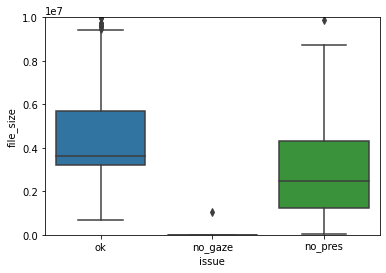

In [18]:
%matplotlib inline
    
sb.boxplot(data=gaze_check_df, y='file_size', x='issue') 

plt.ylim(-1000,10000000)

Correspondingly, they have fewer recorded gaze datapoints.

(-1000.0, 30000.0)

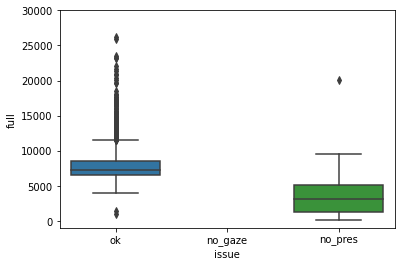

In [19]:
sb.boxplot(data=gaze_check_df, y='full', x='issue') 
plt.ylim(-1000,30000)

Their gaze recordings start *after* the first presentation or end *before* last presentation (or both).
Only one no_pres gaze run starts before pres and ends after... (see below)

In [20]:
gaze_check_df[(gaze_check_df['issue']=='no_pres')
             &(gaze_check_df['pos_end']==True)
             &(gaze_check_df['pos_start']==True)].shape[0]

1

### Three of them are missing behavioral pres start or end times in the dataframe
See the dataframe and notes below

    
### Individual subject notes (manual check)

16_2019_Oct_08: data appears normal (sust, group 2)

24_2019_Apr_11: behavioral df missing timing & response info for the last six trials of run 4's presentation block (var, group 1)

30_2020_Jan_13: data appears normal (var, group 2)
    


In [21]:
gaze_check_df[gaze_check_df['p_end'].isnull()]

,issue,exp,group,subject,run,pres,full,file_size,g_start,g_end,p_start,p_end,m_end,experiment,start_diff,end_diff,mem_end_diff,pos_start,pos_end
282,no_pres,../sustained_attention_experiment/data/,group2,16_2019_Oct_08,2,NaN,6241.0,8728963.0,1.570543e+09,1.570543e+09,NaN,NaN,NaN,..,NaN,NaN,NaN,False,False
652,no_pres,../variable_attention_experiment/data/,group1,24_2019_Apr_11,4,NaN,8819.0,4127851.0,1.555010e+09,1.555011e+09,1.555011e+09,NaN,1.555011e+09,..,413.059526,NaN,19.184373,True,False
758,no_pres,../variable_attention_experiment/data/,group2,30_2020_Jan_13,6,NaN,8480.0,3916990.0,1.578938e+09,1.578938e+09,NaN,NaN,NaN,..,NaN,NaN,NaN,False,False


### Here is a look at all of the no_pres runs

Check out the runs with no pres gaze

In [22]:
gaze_check_df[(gaze_check_df['issue']=='no_pres')].head()

,issue,exp,group,subject,run,pres,full,file_size,g_start,g_end,p_start,p_end,m_end,experiment,start_diff,end_diff,mem_end_diff,pos_start,pos_end
137,no_pres,../sustained_attention_experiment/data/,group1,08_2018_Oct_03,1,NaN,149.0,62764.0,1.538577e+09,1.538577e+09,1.538577e+09,1.538577e+09,1.538577e+09,..,55.429519,-101.579972,-257.787738,True,False
246,no_pres,../sustained_attention_experiment/data/,group2,34_2019_Oct_13,6,NaN,57.0,26462.0,1.570975e+09,1.570975e+09,1.570975e+09,1.570975e+09,1.570975e+09,..,23.174900,-70.372000,-193.677500,True,False
257,no_pres,../sustained_attention_experiment/data/,group2,7_2019_Oct_13,1,NaN,5205.0,2393281.0,1.570998e+09,1.570998e+09,1.570998e+09,1.570998e+09,1.570998e+09,..,-64.338800,-289.008200,-413.488400,False,False
269,no_pres,../sustained_attention_experiment/data/,group2,13_2019_Oct_14,5,NaN,3613.0,4855470.0,1.571080e+09,1.571080e+09,1.571080e+09,1.571080e+09,1.571080e+09,..,-95.674000,185.080600,61.788000,False,True
282,no_pres,../sustained_attention_experiment/data/,group2,16_2019_Oct_08,2,NaN,6241.0,8728963.0,1.570543e+09,1.570543e+09,NaN,NaN,NaN,..,NaN,NaN,NaN,False,False


In [23]:
p_group = p.groupby('Run', as_index=False).count() 
p_group

,Run,Unnamed: 0,avg,fix,lefteye,raw,righteye,state,time,timestamp,...,xRaw_lefteye,yRaw_lefteye,av_x_coord,av_y_coord,Subject,UniqueID,Group,Experiment,Trial,Behavior_Image_Start
0,0,816,816,816,816,816,816,816,816,816,...,816,816,816,816,816,816,816,816,816,816
1,1,816,816,816,816,816,816,816,816,816,...,816,816,816,816,816,816,816,816,816,816
2,2,487,487,487,487,487,487,487,487,487,...,487,487,487,487,487,487,487,487,487,487
3,3,810,810,810,810,810,810,810,810,810,...,810,810,810,810,810,810,810,810,810,810
4,4,680,680,680,680,680,680,680,680,680,...,680,680,680,680,680,680,680,680,680,680
5,5,813,813,813,813,813,813,813,813,813,...,813,813,813,813,813,813,813,813,813,813
6,6,812,812,812,812,812,812,812,812,812,...,812,812,812,812,812,812,812,812,812,812
7,7,798,798,798,798,798,798,798,798,798,...,798,798,798,798,798,798,798,798,798,798


In [24]:
p.head()

,Unnamed: 0,avg,fix,lefteye,raw,righteye,state,time,timestamp,Run,...,xRaw_lefteye,yRaw_lefteye,av_x_coord,av_y_coord,Subject,UniqueID,Group,Experiment,Trial,Behavior_Image_Start
0,24751,"{'x': 1029.7119, 'y': 587.9123}",True,"{'avg': {'x': 1050.0991, 'y': 604.3253}, 'pcen...","{'x': 1017.1755, 'y': 571.2587}","{'avg': {'x': 1010.4808, 'y': 571.0043}, 'pcen...",7,551072119,1.581099e+09,0,...,1018.6279,565.3806,1017.17555,571.2587,0,112,2,/variabl,0.0,1.581099e+09
1,24752,"{'x': 1029.7462, 'y': 588.1995}",True,"{'avg': {'x': 1050.4081, 'y': 603.8857}, 'pcen...","{'x': 1028.8254, 'y': 589.9578}","{'avg': {'x': 1009.9166, 'y': 571.0728}, 'pcen...",7,551072154,1.581099e+09,0,...,1053.8757,606.8762,1028.82540,589.9578,0,112,2,/variabl,0.0,1.581099e+09
2,24753,"{'x': 1029.6157, 'y': 588.2717}",True,"{'avg': {'x': 1050.5505, 'y': 603.4218}, 'pcen...","{'x': 1035.4884, 'y': 590.6418}","{'avg': {'x': 1010.1906, 'y': 571.3847}, 'pcen...",7,551072189,1.581099e+09,0,...,1052.4294,601.5439,1035.48840,590.6418,0,112,2,/variabl,0.0,1.581099e+09
3,24754,"{'x': 1029.7321, 'y': 588.4705}",True,"{'avg': {'x': 1050.424, 'y': 603.5233}, 'pcent...","{'x': 1022.9224, 'y': 589.1093}","{'avg': {'x': 1009.2179, 'y': 570.4584}, 'pcen...",7,551072223,1.581099e+09,0,...,1049.0156,612.5626,1022.92240,589.1093,0,112,2,/variabl,0.0,1.581099e+09
4,24755,"{'x': 1029.5458, 'y': 588.3175}",True,"{'avg': {'x': 1050.9958, 'y': 602.9319}, 'pcen...","{'x': 1036.3113, 'y': 578.6135}","{'avg': {'x': 1008.8527, 'y': 569.2892}, 'pcen...",7,551072258,1.581099e+09,0,...,1066.2775,601.0239,1036.31135,578.6135,0,112,2,/variabl,0.0,1.581099e+09
